In [11]:
# !git clone 'https://github.com/Lorenz92/SKADC1.git'
# % cd SKADC1
# !echo $PWD

In [1]:
import pandas as pd
import numpy as np
import requests
import matplotlib.pyplot as plt
import sys
from astropy.io import fits
import os
import statistics

import src.dataset as dataset
import src.config as config
from src.utils import *
import src.preprocessing as prep
import src.models as models

path = config.TRAIN_PATCHES_FOLDER


# from src.config import * 

%load_ext autoreload
%autoreload 2

np.random.seed(config.RANDOM_SEED)

In [13]:
for download_info in config.required_files:
    if not os.path.exists(os.path.join(config.TRAIN_DATA_FOLDER, download_info['file_name'])):
        download_data(download_info['file_name'], download_info['url'], config.DOWNLOAD_FOLDER)

In [2]:
# Dataset parsing and loading
# use "subset" to load a small portion of data for development/debugging purposes
# ska_dataset_cleanedByClaran = dataset.SKADataset(train_set_path=config.TRAIN_SET_PATH_CLEANED, subset=config.DATA_SUBSET)

# ska_dataset = dataset.SKADataset(train_set_path=config.TRAIN_SET_PATH, subset=config.DATA_SUBSET)
ska_dataset = dataset.SKADataset(train_set_path=config.TRAIN_SET_PATH_CLEANED, subset=config.DATA_SUBSET)

# print(ska_dataset_cleanedByClaran.raw_train_df.shape)
print(ska_dataset.raw_train_df.shape)
ska_dataset.raw_train_df.head()

(19222, 15)


,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,PA,SIZE,CLASS,SELECTION,x,y
0,24121695,-0.642227,-29.775242,-0.642316,-29.775211,0.000035,0.000000,5.600,5.551,328.554,1,1,1,19704.519,17712.942
1,20167150,-0.390473,-29.867493,-0.390667,-29.868851,0.029555,0.016924,107.110,43.263,191.258,1,1,1,18401.338,17160.919
2,20045120,-0.021411,-29.643486,-0.021359,-29.643561,0.000653,0.012185,5.037,3.525,276.587,1,1,1,16493.600,18506.577
3,33938384,-0.316375,-29.697647,-0.316375,-29.697647,0.000017,0.000000,0.847,0.266,346.641,2,1,1,18020.319,18182.095
4,7527248,-0.336528,-29.627335,-0.336527,-29.627338,0.000054,0.044763,3.343,1.515,279.006,1,1,1,18125.824,18600.680


In [3]:
data_560Mhz_1000h_fits = fits.open('./data/training/560Mhz_1000h.fits')
# pb_560Mhz_1000h_fits = fits.open('./data/training/PrimaryBeam_B1.fits')
# data_560Mhz_1000h_fits.info()
data_560Mhz_1000h_fits.filename()

# print(data_560Mhz_1000h_fits[0].data)
# print(data_560Mhz_1000h_fits[0].data.shape)

data_560Mhz_1000h = data_560Mhz_1000h_fits[0].data[0,0]


### Preprocessing

In [4]:
ska_dataset.convert_boxes_to_px_coord(ska_dataset.raw_train_df, data_560Mhz_1000h_fits)
#coords = ska_dataset._convert_boxes_to_px_coord(ska_dataset.raw_train_df, data_560Mhz_1000h_fits[0].header )

100%|██████████| 19222/19222 [00:03<00:00, 6249.66it/s]
(19222, 15)
15
9
(19207, 15)
15
0
Enlarging bboxes...
DONE - Enlarging bboxes...


In [5]:
df_train = ska_dataset.cleaned_train_df
df_train.head()

,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,PA,...,y,x1,y1,x2,y2,major_semia_px,minor_semia_px,pa_in_rad,width,height
0,24121695.0,-0.642227,-29.775242,-0.642316,-29.775211,0.000035,0.000000,5.600,5.551,328.554,...,17712.942,19699.889820,17708.334874,19709.135520,17717.543623,4.633850,4.593304,5.734349,9.245699,9.208748
1,20167150.0,-0.390473,-29.867493,-0.390667,-29.868851,0.029555,0.016924,107.110,43.263,191.258,...,17160.919,18314.128617,17121.775102,18488.540079,17200.059688,88.630651,35.798972,3.338082,174.411463,78.284586
2,20045120.0,-0.021411,-29.643486,-0.021359,-29.643561,0.000653,0.012185,5.037,3.525,276.587,...,18506.577,16490.663037,18502.418816,16496.536575,18510.726749,4.167982,2.916843,4.827354,5.873538,8.307933
3,33938384.0,-0.316375,-29.697647,-0.316375,-29.697647,0.000017,0.000000,0.847,0.266,346.641,...,18182.095,18006.643019,18176.725279,18033.994981,18187.464721,0.700870,0.220108,6.050027,27.351962,10.739442
4,7527248.0,-0.336528,-29.627335,-0.336527,-29.627338,0.000054,0.044763,3.343,1.515,279.006,...,18600.680,18124.509296,18597.936034,18127.132703,18603.414392,2.766243,1.253622,4.869573,2.623407,5.478358


In [29]:
# df_train_BKP = df_train
df_train_BKP.head()


,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,PA,...,y,x1,y1,x2,y2,major_semia_px,minor_semia_px,pa_in_rad,width,height
0,24121695.0,-0.642227,-29.775242,-0.642316,-29.775211,0.000035,0.000000,5.600,5.551,328.554,...,17712.942,19699.889820,17708.334874,19709.135520,17717.543623,4.633850,4.593304,5.734349,9.245699,9.208748
1,20167150.0,-0.390473,-29.867493,-0.390667,-29.868851,0.029555,0.016924,107.110,43.263,191.258,...,17160.919,18314.128617,17121.775102,18488.540079,17200.059688,88.630651,35.798972,3.338082,174.411463,78.284586
2,20045120.0,-0.021411,-29.643486,-0.021359,-29.643561,0.000653,0.012185,5.037,3.525,276.587,...,18506.577,16490.663037,18502.418816,16496.536575,18510.726749,4.167982,2.916843,4.827354,5.873538,8.307933
3,33938384.0,-0.316375,-29.697647,-0.316375,-29.697647,0.000017,0.000000,0.847,0.266,346.641,...,18182.095,18018.267603,18181.289542,18022.370397,18182.900458,0.700870,0.220108,6.050027,4.102794,1.610916
4,7527248.0,-0.336528,-29.627335,-0.336527,-29.627338,0.000054,0.044763,3.343,1.515,279.006,...,18600.680,18124.509296,18597.936034,18127.132703,18603.414392,2.766243,1.253622,4.869573,2.623407,5.478358


In [6]:
df_train[['width', 'height']].describe()

,width,height
count,19207.000000,19207.000000
mean,18.725258,18.772347
std,16.677485,16.700893
min,0.033099,0.033099
25%,8.024738,8.167728
50%,14.282259,14.458358
75%,24.195920,24.223741
max,229.759104,309.488519


In [6]:
x1_min = int(np.floor(min(df_train['x1'])))
y1_min = int(np.floor(min(df_train['y1'])))

x2_max = int(np.floor(max(df_train['x2'])))
y2_max = int(np.floor(max(df_train['y2'])))

data_560Mhz_1000h_train = data_560Mhz_1000h[y1_min:y2_max, x1_min:x2_max]
data_560Mhz_1000h_train.shape


(3279, 3573)

(array([1.725e+03, 4.990e+02, 2.400e+02, 1.080e+02, 3.100e+01, 2.100e+01,
        1.500e+01, 8.000e+00, 6.000e+00, 2.000e+00, 1.300e+01, 5.000e+00,
        3.000e+00, 3.000e+00, 3.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 0.000e+00, 5.000e+00, 2.000e+00, 3.000e+00,
        2.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00]),
 array([1.0000e-04, 2.4750e-04, 3.9500e-04, 5.4250e-04, 6.9000e-04,
        8.3750e-04, 9.8500e-04, 1.1325e-03, 1.2800e-03, 1.4275e-03,
        1.5750e-03, 1.7225e-03, 1.8700e-03, 2.0175e-03, 2.1650e-03,
        2.3125e-03, 2.4600e-03, 2.6075e-03, 2.7550e-03, 2.9025e-03,
        3.0500e-03, 3.1975e-03, 3.3450e-03, 3.4925e-03, 3.6400e-03,
        3.7875e-03, 3.9350e-03, 4.0825e-03, 4.2300e-03, 4.3775e-03,
        4.5250e-03, 4.6725e-03, 4.8200e-03, 4.9675e-03, 5.1150e-03,
        5.2625e-03, 5.4100

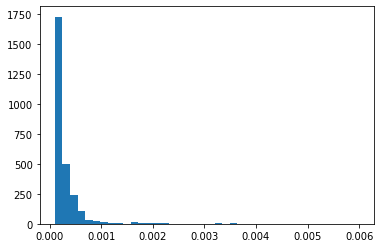

In [7]:
# histogram of noise (- noise, + noise)
# we know that negative values are due to noise, and we assume a gaussian noise distribution

data_flat = data_560Mhz_1000h_train.flatten()
min_val = min(data_flat)
plt.hist(data_flat, bins = 40, range = (0.0001, 0.006))#abs(min_val)))

In [9]:
# fits_max_data_560Mhz_1000h = np.max(data_560Mhz_1000h)
# print(fits_max_data_560Mhz_1000h)

# data_560Mhz_1000h_train_clipped = np.clip(data_560Mhz_1000h_train, a_min=0, a_max=fits_max_data_560Mhz_1000h)

# # NB the computation of the mean val must be after the noise removal
# data_flat = data_560Mhz_1000h_train_clipped.flatten()
# mean_GLval = statistics.mean(data_flat)
# max_GLval = max(data_flat)
# min_GLval = min(data_flat)
# print(mean_GLval)
# print(max_GLval)
# print(min_GLval)

0.48094657
3.8127698e-07
0.006585681
0.0


In [8]:
data_560Mhz_1000h_train_clipped = np.clip(data_560Mhz_1000h_train, a_min=0, a_max=np.max(data_560Mhz_1000h))


  0%|          | 0/18 [00:00<?, ?it/s]image saved


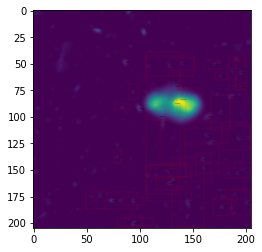


  6%|▌         | 1/18 [00:01<00:26,  1.57s/it]image saved


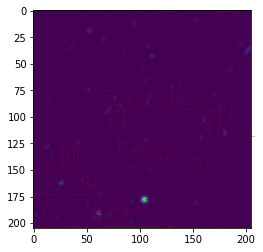


 11%|█         | 2/18 [00:03<00:25,  1.61s/it]image saved


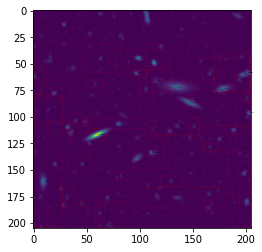


 17%|█▋        | 3/18 [00:05<00:29,  1.96s/it]image saved


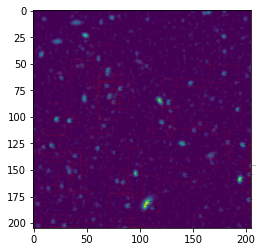


 22%|██▏       | 4/18 [00:08<00:32,  2.31s/it]image saved


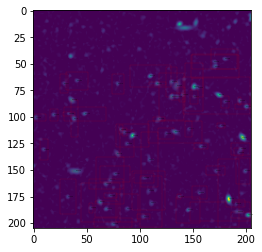


 28%|██▊       | 5/18 [00:10<00:29,  2.29s/it]image saved


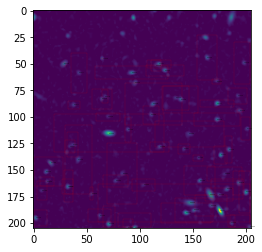


 33%|███▎      | 6/18 [00:12<00:27,  2.29s/it]image saved


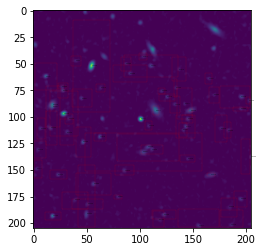


 39%|███▉      | 7/18 [00:15<00:24,  2.22s/it]image saved


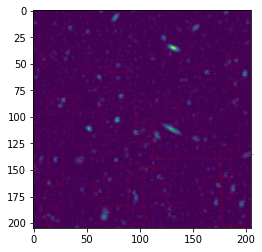


 44%|████▍     | 8/18 [00:17<00:21,  2.14s/it]image saved


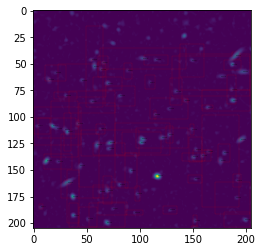


 50%|█████     | 9/18 [00:19<00:19,  2.19s/it]image saved


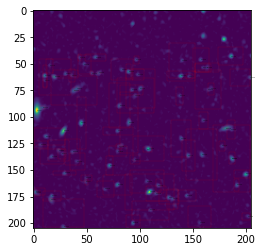


 56%|█████▌    | 10/18 [00:22<00:18,  2.35s/it]image saved


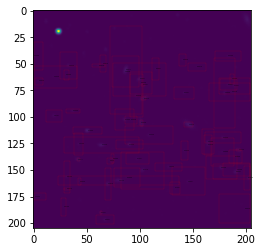


100%|██████████| 16/16 [00:24<00:00,  1.51s/it]


In [9]:
patch_list={}
patch_list = ska_dataset._split_in_patch(data_560Mhz_1000h_train_clipped, df_train, data_560Mhz_1000h_fits.filename(), x1_min, y1_min, 205) # Remember to remove internal return

In [18]:
ska_dataset.proc_train_df[ska_dataset.proc_train_df['ID']==14777429]

,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,PA,...,y1s,x2s,y2s,patch_name,patch_xo,patch_yo,patch_dim,bbox_w,bbox_h,class_label
162,14777429,-0.025579,-29.921852,-0.025579,-29.921852,0.000008,-0.0,0.803,0.244,-12.322,...,147.717374,205.095652,157.434626,560Mhz_1000h_16323_16696,16323,16696,600,26.023305,9.717253,2_1
13,14777429,-0.025579,-29.921852,-0.025579,-29.921852,0.000008,-0.0,0.803,0.244,-12.322,...,147.717374,205.000000,157.434626,560Mhz_1000h_16323_16696,16323,16696,205,25.927652,9.717253,2_1
13,14777429,-0.025579,-29.921852,-0.025579,-29.921852,0.000008,-0.0,0.803,0.244,-12.322,...,147.717374,205.000000,157.434626,560Mhz_1000h_16323_16696,16323,16696,205,25.927652,9.717253,2_1
13,14777429,-0.025579,-29.921852,-0.025579,-29.921852,0.000008,-0.0,0.803,0.244,-12.322,...,147.717374,205.000000,157.434626,560Mhz_1000h_16323_16696,16323,16696,205,25.927652,9.717253,2_1
13,14777429,-0.025579,-29.921852,-0.025579,-29.921852,0.000008,-0.0,0.803,0.244,-12.322,...,147.717374,205.000000,157.434626,560Mhz_1000h_16323_16696,16323,16696,205,25.927652,9.717253,2_1


In [15]:
ska_dataset.proc_train_df.head()

,ID,RA (core),DEC (core),RA (centroid),DEC (centroid),FLUX,Core frac,BMAJ,BMIN,PA,...,y1s,x2s,y2s,patch_name,patch_xo,patch_yo,patch_dim,bbox_w,bbox_h,class_label
0,34804464,-0.009497,-29.902887,-0.009526,-29.902887,0.000030,0.010107,5.316,2.413,291.791,...,236.423959,581.666878,244.726426,560Mhz_1000h_15853_16721,15853,16721,600,4.941215,8.302467,1_1
1,13302538,-0.005224,-29.939449,-0.005224,-29.939449,0.000017,0.861438,0.076,0.076,259.451,...,3.882612,575.836388,41.615388,560Mhz_1000h_15853_16721,15853,16721,600,37.732776,37.732776,2_1
2,1528443,-0.002424,-29.851810,-0.002424,-29.851810,0.000027,-0.000000,3.821,1.334,82.360,...,541.746392,543.699522,548.020676,560Mhz_1000h_15853_16721,15853,16721,600,2.344050,6.274285,2_1
3,29158240,-0.002566,-29.917469,-0.002566,-29.917469,0.000036,-0.000000,1.474,0.443,-7.448,...,34.791474,600.000000,272.616526,560Mhz_1000h_15853_16721,15853,16721,600,419.853366,237.825052,2_1
4,8888326,-0.000018,-29.858444,-0.000018,-29.858444,0.000027,-0.000000,3.983,1.193,-89.290,...,0.000000,600.000000,600.000000,560Mhz_1000h_15853_16721,15853,16721,600,366.290260,600.000000,2_1


## Preprocessing - TODO:
- Ingrandire bbox
- unire bbox sovrapposte?

In [22]:
# Download VGG16 weights
# 'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
if not os.path.exists(os.path.join(config.MODEL_WEIGHTS, 'vgg16')):
    download_data('vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 
    'https://github.com/fchollet/deep-learning-models/releases/download/v0.1/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', config.MODEL_WEIGHTS + '/vgg16')


In [10]:
import keras
from keras.layers import Input
from src.layers import Expander, vgg16, RpnNet, RoiPoolingConv, Classifier
import src.models as models
import src.layers as layers

vgg16_weight_path = os.path.join('./model/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

input_shape_1=(205,205,1)
input_shape_2=(None, 4)

rpn_model, cls_model, total_model = models.e2e(input_shape_1=input_shape_1, input_shape_2=input_shape_2, anchor_num=config.anchor_num, pooling_regions=7, num_rois=4, num_classes=4, weights=vgg16_weight_path)

rpn_model.summary()
cls_model.summary()
total_model.summary()

Model: "RegionProposal"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 205, 205, 1)]     0         
_________________________________________________________________
Custom_input_layer (Expander (None, 205, 205, 3)       6         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 205, 205, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 205, 205, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 102, 102, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 102, 102, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 102, 102, 128)  

In [11]:
import tensorflow as tf
from keras import backend as K


lambda_rpn_regr = 1.0
lambda_rpn_class = 1.0

lambda_cls_regr = 1.0
lambda_cls_class = 1.0

epsilon = 1e-4

def rpn_loss_regr(num_anchors):
    """Loss function for rpn regression
    Args:
        num_anchors: number of anchors (9 in here)
    Returns:
        Smooth L1 loss function 
                           0.5*x*x (if x_abs < 1)
                           x_abx - 0.5 (otherwise)
    """
    def rpn_loss_regr_fixed_num(y_true, y_pred):

        # x is the difference between true value and predicted value
        x = y_true[:, :, :, 4 * num_anchors:] - y_pred

        # absolute value of x
        x_abs = K.abs(x)

        # If x_abs <= 1.0, x_bool = 1
        x_bool = K.cast(K.less_equal(x_abs, 1.0), tf.float32)

        return lambda_rpn_regr * K.sum(
            y_true[:, :, :, :4 * num_anchors] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :, :4 * num_anchors])

    return rpn_loss_regr_fixed_num

def rpn_loss_cls(num_anchors):
    """Loss function for rpn classification
    Args:
        num_anchors: number of anchors (9 in here)
        y_true[:, :, :, :9]: [0,1,0,0,0,0,0,1,0] means only the second and the eighth box is valid which contains pos or neg anchor => isValid
        y_true[:, :, :, 9:]: [0,1,0,0,0,0,0,0,0] means the second box is pos and eighth box is negative
    Returns:
        lambda * sum((binary_crossentropy(isValid*y_pred,y_true))) / N
    """
    def rpn_loss_cls_fixed_num(y_true, y_pred):

            return lambda_rpn_class * K.sum(y_true[:, :, :, :num_anchors] * K.binary_crossentropy(y_pred[:, :, :, :num_anchors], y_true[:, :, :, :num_anchors])) / K.sum(epsilon + y_true[:, :, :, :num_anchors]) # Corretto num anchors qui
            

    return rpn_loss_cls_fixed_num

def class_loss_regr(num_classes):
    """Loss function for rpn regression
    Args:
        num_anchors: number of anchors (9 in here)
    Returns:
        Smooth L1 loss function 
                           0.5*x*x (if x_abs < 1)
                           x_abs - 0.5 (otherwise)
    """
    def class_loss_regr_fixed_num(y_true, y_pred):
        # print('1', y_true.shape, y_pred.shape)
        # print('2', y_true, y_pred)
        # print('suca'*30)
        
        # tf.print(y_true, y_pred, output_stream=sys.stderr, sep=',')

        x = y_true[:, :, 4*num_classes:] - y_pred # Here <y_true[:, :, 4*num_classes:]> is the y_class_regr_coords of Y2 in calc_iou, so it represents the roi coordinates
        # tf.print('x = ', x, output_stream=sys.stderr, sep=',')

        x_abs = K.abs(x)
        # tf.print('x_abs = ', x_abs, output_stream=sys.stderr, sep=',')

        x_bool = K.cast(K.less_equal(x_abs, 1.0), 'float32')
        # tf.print('x_bool = ', x_bool, output_stream=sys.stderr, sep=',')

        # tf.print('num_1', y_true[:, :, :4*num_classes], output_stream=sys.stderr, sep=',')
        # tf.print('num_2', x_bool * (0.5 * x * x), output_stream=sys.stderr, sep=',')
        # tf.print('num_3', (1 - x_bool) * (x_abs - 0.5), output_stream=sys.stderr, sep=',')
        # tf.print('num_4', (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5)), output_stream=sys.stderr, sep=',')
        # tf.print('num_5', y_true[:, :, :4*num_classes] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5)), output_stream=sys.stderr, sep=',')
        # tf.print('num_sum', K.sum(y_true[:, :, :4*num_classes] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))), output_stream=sys.stderr, sep=',')
        # tf.print('den_sum', K.sum(epsilon + y_true[:, :, :4*num_classes]), output_stream=sys.stderr, sep=',')



        z = lambda_cls_regr * K.sum(y_true[:, :, :4*num_classes] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :4*num_classes]) # Here <y_true[:, :, :4*num_classes]> is the y_class_regr_label of Y2 in calc_iou, so it represents a mask for the roi to be considered
        print('!'*30)
        tf.print('z = ', z, output_stream=sys.stderr, sep=',')


        return z
    return class_loss_regr_fixed_num

def class_loss_cls(y_true, y_pred):
    return lambda_cls_class * K.mean(K.categorical_crossentropy(y_true[0, :, :], y_pred[0, :, :]))

In [12]:
from keras.optimizers import Adam

num_classes=4

optimizer = Adam(lr=1e-5)
optimizer_classifier = Adam(lr=1e-5)

rpn_model.compile(optimizer=optimizer, loss=[rpn_loss_cls(config.anchor_num), rpn_loss_regr(config.anchor_num)])
cls_model.compile(optimizer=optimizer_classifier, loss=[class_loss_cls, class_loss_regr(num_classes-1)], loss_weights=[1,1], metrics=['accuracy'])
# cls_model.compile(optimizer=optimizer_classifier, loss=[class_loss_cls, class_loss_regr(num_classes-1)], metrics={'dense_class_{}'.format(num_classes-1): 'accuracy'})
total_model.compile(optimizer='sgd', loss='mae')

In [26]:
# total_model.save_weights('./test.h5')

In [27]:
# rpn_model.load_weights('./test.h5', by_name=True)

In [28]:
# # Check that all of the pretrained weights have been loaded.
# import numpy as np
# for i, j in zip(total_model.weights, rpn_model.weights):
#     # print(i)
#     # print(j)
#     assert np.allclose(i,j), 'Diversi!'

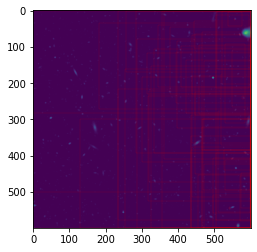

In [38]:
print_img(path, '11400_15853_16721_600')

## datagen + calc_rpn -> rpn_net -> rpn_to_roi -> calc_iou -> cls_net

In [13]:
datagen = prep.get_anchor_gt(path, patch_list)
image, [y_rpn_cls_true, y_rpn_reg_true], img_data_aug, debug_img, num_pos = next(datagen)

0_16323_16696_205


In [74]:
batch_loss = rpn_model.train_on_batch(image, [y_rpn_cls_true, y_rpn_reg_true])
print(batch_loss)

[8.485099792480469, 7.335635185241699, 1.14946448802948]


In [75]:
P_rpn = rpn_model.predict_on_batch(image)
P_rpn

[array([[[[0.5255422 , 0.5720518 , 0.5776015 , ..., 0.44220337,
           0.53940874, 0.4535818 ],
          [0.5646208 , 0.53938395, 0.5862635 , ..., 0.3185962 ,
           0.589738  , 0.3828799 ],
          [0.5637189 , 0.55508065, 0.61469984, ..., 0.32813662,
           0.57706636, 0.374009  ],
          ...,
          [0.5938793 , 0.54847336, 0.63752526, ..., 0.3128234 ,
           0.5742743 , 0.3551014 ],
          [0.60212004, 0.5508608 , 0.64907736, ..., 0.31403464,
           0.57623607, 0.3585583 ],
          [0.56592166, 0.50422746, 0.58779895, ..., 0.3286033 ,
           0.53363156, 0.39317697]],
 
         [[0.54157656, 0.5248492 , 0.5066755 , ..., 0.40461007,
           0.5891456 , 0.44425657],
          [0.4975522 , 0.5502599 , 0.6093766 , ..., 0.3707844 ,
           0.58087903, 0.34903467],
          [0.52596223, 0.53239095, 0.6123607 , ..., 0.3909655 ,
           0.5918734 , 0.34496698],
          ...,
          [0.5808792 , 0.54469305, 0.6223529 , ..., 0.40237093,
   

In [76]:
R = rpn_to_roi(P_rpn[0], P_rpn[1], use_regr=True, max_boxes=300, overlap_thresh=0.7)
print(len(R))
R

rpn_layer=(1, 12, 12, 21)
regr_layer=(1, 12, 12, 84)
300


array([[ 3,  2,  4,  3],
       [ 2,  2,  3,  3],
       [ 4,  2,  5,  3],
       ...,
       [ 8,  6, 11, 10],
       [ 6,  9, 11, 11],
       [ 6,  0,  8,  2]])

In [77]:
class_mapping = {'1':0, '2':1, '3':2, 'bg':3}

X2, Y1, Y2, IouS = calc_iou(R, img_data_aug, class_mapping)

[0.10191333625628868, 0.18721485952906955, 0.23950947889119226, 0.18045284436758435, 0.23950947889119226, 0.2390173450574901, 0.1644083749089475, 0.33279663628379064, 0.578840130815119, 0.17947784922838286, 0.28518121295651094, 0.12991247958606786, 0.26625771827785116, 0.24011782031437937, 0.24124675570894388, 0.4135355915080131, 0.38079791591750545, 0.39998046326740033, 0.13439173442527008, 0.22699728911757147, 0.16672116430322576, 0.29937331320972954, 0.27762156192209214, 0.2806681004101844, 0.35873593456425945, 0.3778150001189073, 0.3108832297990724, 0.27414424803605447, 0.16672116430322576, 0.30122738720752246, 0.30122738720752246, 0.12352415563388364, 0.12352415563388364, 0.25998967590802285, 0.35701503713258964, 0.1694931304117426, 0.18301821494081189, 0.13804716230562014, 0.23312763656369456, 0.24312021913039075, 0.2365992117484891, 0.21638120453832035, 0.35491607958045257, 0.3566464821725961, 0.3566464821725961, 0.25684808882176785, 0.23127788197996116, 0.32201053808620267, 0.3

In [78]:
np.where(np.array(IouS) > .5)

(array([  8,  64,  68,  81,  87, 133]),)

In [79]:
Y2

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [80]:
neg_samples = np.where(Y1[0, :, -1] == 1) # --> these are bg anchors
pos_samples = np.where(Y1[0, :, -1] == 0)

# print('neg_samples = ', neg_samples)
# print('pos_samples = ', pos_samples)

if len(neg_samples) > 0:
    neg_samples = neg_samples[0]
else:
    neg_samples = []

if len(pos_samples) > 0:
    pos_samples = pos_samples[0]
else:
    pos_samples = []

# rpn_accuracy_rpn_monitor.append(len(pos_samples))
# rpn_accuracy_for_epoch.append((len(pos_samples)))

if C.num_rois > 1:
    # If number of positive anchors is larger than 4//2 = 2, randomly choose 2 pos samples
    if len(pos_samples) < C.num_rois//2:
        selected_pos_samples = pos_samples.tolist()
    else:
        selected_pos_samples = np.random.choice(pos_samples, C.num_rois//2, replace=False).tolist()
    
    # Randomly choose (num_rois - num_pos) neg samples
    try:
        selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=False).tolist()
    except:
        selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=True).tolist()

    # print(selected_pos_samples)
    # print(selected_neg_samples)
    
    # Save all the pos and neg samples in sel_samples
    sel_samples = selected_pos_samples + selected_neg_samples
else:
    # in the extreme case where num_rois = 1, we pick a random pos or neg sample
    selected_pos_samples = pos_samples.tolist()
    selected_neg_samples = neg_samples.tolist()
    if np.random.randint(0, 2):
        sel_samples = random.choice(neg_samples)
    else:
        sel_samples = random.choice(pos_samples)

In [81]:
loss_class = cls_model.train_on_batch([image, X2[:, sel_samples, :]], [Y1[:, sel_samples, :], Y2[:, sel_samples, :]])
print('-'*20)
print(cls_model.metrics_names)
print(loss_class)

z = ,0.562258542
--------------------
['loss', 'cls_loss', 'cls_1_loss', 'cls_accuracy', 'cls_1_accuracy']
[1.8986639976501465, 1.3364053964614868, 0.5622585415840149, 0.75, 0.0]


In [21]:
# Training loop
datagen = prep.get_anchor_gt(path, patch_list)
loss = {
    'loss_rpn': [],
    'loss_rpn_reg': [],
    'loss_rpn_cls': [],
    'loss_cls': [],
    'loss_cls_reg': [],
    'loss_cls_cls': []
}
# build class_mapping
class_mapping = {'1':0, '2':1, '3':2, 'bg':3}

for epoch in range(300):
    print(epoch)
    while True:
        try:

            image, [y_rpn_cls_true, y_rpn_reg_true], img_data_aug, debug_img, num_pos = next(datagen)

            batch_loss = rpn_model.train_on_batch(image, [y_rpn_cls_true, y_rpn_reg_true])

            loss['loss_rpn'].append(batch_loss[0])
            loss['loss_rpn_reg'].append(batch_loss[1])
            loss['loss_rpn_cls'].append(batch_loss[2])

            print(batch_loss)

            # Get predicted rpn from rpn model [rpn_cls, rpn_regr]
            P_rpn = rpn_model.predict_on_batch(image)

            # R: bboxes (shape=(300,4))
            # Convert rpn layer to roi bboxes
            R = rpn_to_roi(P_rpn[0], P_rpn[1], use_regr=True, max_boxes=300, overlap_thresh=0.7)
            # print(R.shape)
            
            # # note: calc_iou converts from (x1,y1,x2,y2) to (x,y,w,h) format
            # # X2: bboxes that iou > C.classifier_min_overlap for all gt bboxes in 300 non_max_suppression bboxes
            # # Y1: one hot code for bboxes from above => x_roi (X)
            # # Y2: corresponding labels and corresponding gt bboxes
            X2, Y1, Y2, IouS = calc_iou(R, img_data_aug, class_mapping)

            # print(X2)
            # print('Y2.shape - ', Y2.shape)
            # print(Y2.dtype)
            # print(IouS)

            # # If X2 is None means there are no matching bboxes
            # if X2 is None:
            #     rpn_accuracy_rpn_monitor.append(0)
            #     rpn_accuracy_for_epoch.append(0)
            #     continue
            
            # Find out the positive anchors and negative anchors
            neg_samples = np.where(Y1[0, :, -1] == 1) # --> these are bg anchors
            pos_samples = np.where(Y1[0, :, -1] == 0)

            # print('neg_samples = ', neg_samples)
            # print('pos_samples = ', pos_samples)

            if len(neg_samples) > 0:
                neg_samples = neg_samples[0]
            else:
                neg_samples = []

            if len(pos_samples) > 0:
                pos_samples = pos_samples[0]
            else:
                pos_samples = []

            # rpn_accuracy_rpn_monitor.append(len(pos_samples))
            # rpn_accuracy_for_epoch.append((len(pos_samples)))

            if C.num_rois > 1:
                # If number of positive anchors is larger than 4//2 = 2, randomly choose 2 pos samples
                if len(pos_samples) < C.num_rois//2:
                    selected_pos_samples = pos_samples.tolist()
                else:
                    selected_pos_samples = np.random.choice(pos_samples, C.num_rois//2, replace=False).tolist()
                
                # Randomly choose (num_rois - num_pos) neg samples
                try:
                    selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=False).tolist()
                except:
                    selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=True).tolist()

                # print(selected_pos_samples)
                # print(selected_neg_samples)
                
                # Save all the pos and neg samples in sel_samples
                sel_samples = selected_pos_samples + selected_neg_samples
            else:
                # in the extreme case where num_rois = 1, we pick a random pos or neg sample
                selected_pos_samples = pos_samples.tolist()
                selected_neg_samples = neg_samples.tolist()
                if np.random.randint(0, 2):
                    sel_samples = random.choice(neg_samples)
                else:
                    sel_samples = random.choice(pos_samples)

            # print(sel_samples)
            # print(Y1[:, sel_samples, :].dtype)
            # print('Y2.shape = ', Y2[:, sel_samples, :].shape)
            # training_data: [X, X2[:, sel_samples, :]]
            # labels: [Y1[:, sel_samples, :], Y2[:, sel_samples, :]]
            #  X                     => img_data resized image
            #  X2[:, sel_samples, :] => num_rois (4 in here) bboxes which contains selected neg and pos
            #  Y1[:, sel_samples, :] => one hot encode for num_rois bboxes which contains selected neg and pos
            #  Y2[:, sel_samples, :] => labels and gt bboxes for num_rois bboxes which contains selected neg and pos
            loss_class = cls_model.train_on_batch([image, X2[:, sel_samples, :]], [Y1[:, sel_samples, :], Y2[:, sel_samples, :]])
            print('-'*20)
            print(cls_model.metrics_names)
            print(loss_class)
            loss['loss_cls'].append(batch_loss[0])
            loss['loss_cls_reg'].append(batch_loss[2])
            loss['loss_cls_cls'].append(batch_loss[1])
            break

        except Exception as e:
            print('Exception: {}'.format(e))
            continue




Error: Pip module Unable to parse debugpy output, please log an issue with https://github.com/microsoft/vscode-jupyter is required for debugging cells. You will need to install it to debug cells.

TODO - 20210508:
- troncamento rumore a 1e-6?

TODO - 202105016:
- scrivere training loop + save/read pesi per colab + test loop (Lorenzo)

TODO - 20210527:
- scale up di tutto!!! quindi cambiare patch dim e quindi input_shape network
- check soglia di accettabilità quando la box cade in una patch?

TODO - 20210529:
- provare FeaturePyramidNetwork

In [58]:
cls_model.train_on_batch([image, X2[:, sel_samples, :]], [Y1[:, sel_samples, :], Y2[:, sel_samples, :]])

[124.93180847167969, 1.2493181228637695, 0.0, 1.0, 1.0]

In [39]:
r_epochs = 50


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(np.arange(0, r_epochs), loss['loss_rpn_cls'], 'r')
plt.title('loss_rpn_cls')
plt.subplot(1,2,2)
plt.plot(np.arange(0, r_epochs), loss['loss_rpn_reg'], 'r')
plt.title('loss_rpn_reg')
plt.subplot(2,2,1)
plt.plot(np.arange(0, r_epochs), loss['loss_cls_reg'], 'r')
plt.title('loss_cls_clsdd')
plt.subplot(2,2,2)
plt.plot(np.arange(0, r_epochs), loss['loss_cls_cls'], 'r')
plt.title('loss_cls_reg')
plt.show()

plt.plot(np.arange(0, r_epochs), loss['loss_rpn'], 'r')
plt.title('total_loss')
plt.show()

TypeError: list indices must be integers or slices, not str

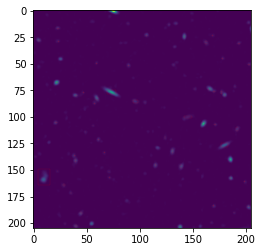

In [28]:
## DEBUG

patch = '1435_1781517815_205'
image_path = os.path.join(config.TRAIN_PATCHES_FOLDER, patch, f"{patch}.npy")
image_data_path = os.path.join(config.TRAIN_PATCHES_FOLDER, patch, f"{patch}.pkl")

p = np.load(image_path)
pdata = pd.read_pickle(image_data_path)

print_img(p, pdata)


In [ ]:
#TODO: Provare YOLO -> forse meglio le efficientNet
# Ablation study
# Provare, a parità di frequenza, le esposizioni diverse come canali

In [1]:
# from tensorflow.keras.applications import EfficientNetB0
# model = EfficientNetB0(weights='imagenet')